In [419]:
# Loading Important Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Stats Modules
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler,PowerTransformer,StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import math
from sklearn.linear_model import Ridge


%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)


In [420]:
# Load the train data

train_data_raw = pd.read_csv('Train.csv')
train_data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,1605,2977,2,01-12-2010 08:26,7.65,17850,35
1,0,755,1444,6,01-12-2010 08:26,4.25,17850,35
2,0,2802,2776,6,01-12-2010 08:26,3.39,17850,35
3,0,2803,1813,6,01-12-2010 08:26,3.39,17850,35
4,0,2855,861,8,01-12-2010 08:26,2.75,17850,35


In [421]:
# Inspect the data set

# Print Shape
print('shape ',train_data_raw.shape )
# Check the non null entries
train_data_raw.info()

# Not a single null column in any data column


shape  (284780, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284780 entries, 0 to 284779
Data columns (total 8 columns):
InvoiceNo      284780 non-null int64
StockCode      284780 non-null int64
Description    284780 non-null int64
Quantity       284780 non-null int64
InvoiceDate    284780 non-null object
UnitPrice      284780 non-null float64
CustomerID     284780 non-null int64
Country        284780 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 17.4+ MB


In [422]:
# CHeck the summary statsitics
train_data_raw.describe()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
count,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000
mean,9955.394083,1573.386807,2023.955573,12.028468,3.451216,15288.224278,32.823846
std,5551.519138,843.604991,1089.812078,295.111588,78.399541,1714.336529,6.743602
min,0.000000,0.000000,0.000000,-80995.000000,0.000000,12346.000000,0.000000
25%,5069.000000,939.000000,1141.000000,2.000000,1.250000,13953.000000,35.000000
50%,10310.000000,1521.000000,1987.000000,5.000000,1.950000,15152.000000,35.000000
75%,14657.000000,2106.000000,2945.000000,12.000000,3.750000,16794.000000,35.000000
max,22188.000000,3683.000000,3895.000000,80995.000000,38970.000000,18287.000000,36.000000


In [423]:
# Splitting the data in test and train

X = train_data_raw.drop('UnitPrice',axis = 1)
Y = train_data_raw[['UnitPrice']]

#X_Train, X_Test , Y_Train, Y_Test = train_test_split(X,Y,test_size = 0.00001, random_state = 150)

#train_data = pd.concat([X_Train,Y_Train], axis = 1)
#test_data = pd.concat([X_Test,Y_Test], axis = 1)
#print('Train_Shape ',train_data.shape)
#print('Test_Shape ',test_data.shape)
train_data = train_data_raw.copy()


In [424]:
# Add a rank column for repeat transactions

train_data['RepeatRank']= train_data.groupby(['StockCode','InvoiceDate','Country'])['InvoiceNo'].cumcount()+1
train_data['Date'] = train_data['InvoiceDate'].apply(lambda x:x.split(" ")[0])
train_data_raw_x =   train_data.groupby(['StockCode','Date','Country','RepeatRank'])['UnitPrice'].mean().reset_index()
train_data_raw_x.columns = ['StockCode','Date','Country','RepeatRank','XTransform']
train_data = pd.merge(train_data,train_data_raw_x,on = ['StockCode','Date','Country','RepeatRank'],how = 'inner').reset_index(drop = True)
# Drop Unwanted Columns
columns_to_drop = ['InvoiceNo', 'StockCode', 'Description','InvoiceDate','CustomerID', 'Country','Date','RepeatRank']
train_data = train_data.drop(columns_to_drop,axis = 1)
train_data.corr()

,Quantity,UnitPrice,XTransform
Quantity,1.000000,-0.000924,-0.000974
UnitPrice,-0.000924,1.000000,0.994659
XTransform,-0.000974,0.994659,1.000000


In [425]:
# Block for functions 

# Detect Outlier % on data using IQR method
def detect_outlier_percent(series):
    upper_quartile = np.percentile(series, 75)
    lower_quartile = np.percentile(series, 25)
    iqr = upper_quartile - lower_quartile
    upper_wisker = upper_quartile + 1.5*iqr
    lower_wisker = lower_quartile - 1.5*iqr
    series_points_above_wiskers = np.where(series>upper_wisker, 1, 0).sum()
    series_points_below_wiskers = np.where(series<lower_wisker, 1, 0).sum()
    return (upper_wisker,lower_wisker)

def remove_outlier(df,series_df,cutoff,col):
    list_to_remove = series_df[series_df[col]>cutoff][col].index.tolist()
    return df[~df[col].isin(list_to_remove)]
    

In [426]:
# Start Univariate Analysis
# Quantity

'''
train_data['Is_Quantity_Neg'] = train_data['Quantity'].apply(lambda x:1 if x<0 else 0 )
train_data['Quantity'] = train_data['Quantity'].apply(lambda x:abs(x) if x<=0 else x )


sns.boxplot(y='Quantity',data = train_data )
plt.show()


# Lets see the upper and the lower cutoff according to boxplot
(upper_cutoff,lower_cutoff) = detect_outlier_percent(train_data['Quantity'])
print('upper_cutoff ',upper_cutoff)
print('lower_cutoff ',lower_cutoff)

# Lets check the variation with percentile

x = [x for x in range(0,101,1)]
y = np.percentile(train_data['Quantity'], x)

sns.lineplot(x,y )
plt.show()

# Lets cap the data at the upper wisker to remove outliers here

train_data['Quantity'] = train_data['Quantity'].apply(lambda x:upper_cutoff if x>=upper_cutoff else x )
#train_data = train_data[train_data['Quantity']<=1500]

print('final_shape ',train_data.shape)
sns.boxplot(y='Quantity',data = train_data )
plt.show()
'''

"\ntrain_data['Is_Quantity_Neg'] = train_data['Quantity'].apply(lambda x:1 if x<0 else 0 )\ntrain_data['Quantity'] = train_data['Quantity'].apply(lambda x:abs(x) if x<=0 else x )\n\n\nsns.boxplot(y='Quantity',data = train_data )\nplt.show()\n\n\n# Lets see the upper and the lower cutoff according to boxplot\n(upper_cutoff,lower_cutoff) = detect_outlier_percent(train_data['Quantity'])\nprint('upper_cutoff ',upper_cutoff)\nprint('lower_cutoff ',lower_cutoff)\n\n# Lets check the variation with percentile\n\nx = [x for x in range(0,101,1)]\ny = np.percentile(train_data['Quantity'], x)\n\nsns.lineplot(x,y )\nplt.show()\n\n# Lets cap the data at the upper wisker to remove outliers here\n\ntrain_data['Quantity'] = train_data['Quantity'].apply(lambda x:upper_cutoff if x>=upper_cutoff else x )\n#train_data = train_data[train_data['Quantity']<=1500]\n\nprint('final_shape ',train_data.shape)\nsns.boxplot(y='Quantity',data = train_data )\nplt.show()\n"

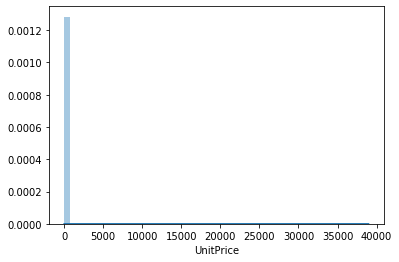

upper_cutoff  7.5
lower_cutoff  -2.5


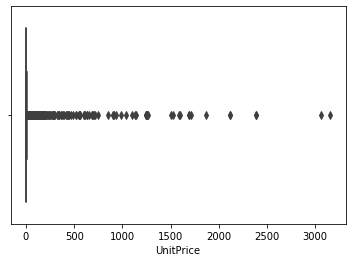

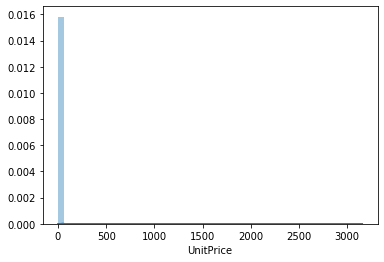

final_shape  (284774, 3)


In [427]:
# Unit Price

sns.distplot(train_data['UnitPrice'] )
plt.show()
(upper_cutoff,lower_cutoff) = detect_outlier_percent(train_data['UnitPrice'])
print('upper_cutoff ',upper_cutoff)
print('lower_cutoff ',lower_cutoff)
train_data = train_data[(train_data['UnitPrice']<= 3200) ]
#train_data['UnitPrice'] = train_data['UnitPrice'].apply(lambda x: upper_cutoff if x>upper_cutoff else x )


#train_data['UnitPrice'] = np.log1p(train_data['UnitPrice'])

sns.boxplot(train_data['UnitPrice'])
plt.show()

sns.distplot(train_data['UnitPrice'] )
plt.show()


print('final_shape ',train_data.shape)



In [428]:
# Stock Code
'''
def transform_stock_code(x):
    if(x<=0.4):
        return 'very_low_price'
    elif(x<=0.9):
        return 'low_price'
    elif(x<=3):
        return 'medium_price'
    elif(x<=5):
        return 'high_price'
    elif(x<=7.5):
        return 'very_high_price'
    else:
        return 'medium_price'

        
train_data_raw_stockcode =  train_data.groupby(['StockCode'])['UnitPrice'].mean().reset_index()
train_data_raw_stockcode.columns = ['StockCode','StockCodeTransform']
#print('percentile_dist_of_stock_price ',np.percentile(train_data_raw_stockcode['UnitPrice'],[10,25,75,90,100]))
#train_data_raw_stockcode['StockCodeTransform'] = train_data_raw_stockcode['UnitPrice'].apply(transform_stock_code)
#train_data_raw_stockcode = train_data_raw_stockcode.drop(['UnitPrice'],axis = 1)
train_data = pd.merge(train_data,train_data_raw_stockcode,on = 'StockCode',how = 'inner').reset_index(drop = True)
#train_data['StockCodeTransform'].value_counts()
train_data.head()
'''


"\ndef transform_stock_code(x):\n    if(x<=0.4):\n        return 'very_low_price'\n    elif(x<=0.9):\n        return 'low_price'\n    elif(x<=3):\n        return 'medium_price'\n    elif(x<=5):\n        return 'high_price'\n    elif(x<=7.5):\n        return 'very_high_price'\n    else:\n        return 'medium_price'\n\n        \ntrain_data_raw_stockcode =  train_data.groupby(['StockCode'])['UnitPrice'].mean().reset_index()\ntrain_data_raw_stockcode.columns = ['StockCode','StockCodeTransform']\n#print('percentile_dist_of_stock_price ',np.percentile(train_data_raw_stockcode['UnitPrice'],[10,25,75,90,100]))\n#train_data_raw_stockcode['StockCodeTransform'] = train_data_raw_stockcode['UnitPrice'].apply(transform_stock_code)\n#train_data_raw_stockcode = train_data_raw_stockcode.drop(['UnitPrice'],axis = 1)\ntrain_data = pd.merge(train_data,train_data_raw_stockcode,on = 'StockCode',how = 'inner').reset_index(drop = True)\n#train_data['StockCodeTransform'].value_counts()\ntrain_data.head()\n"

In [429]:
# Country
'''
def transform_country(x):
    if(x <=1.87):
        return 'very_low_price'
    elif(x<=2.04):
        return 'low_price'
    elif(x<=2.36):
        return 'medium_price'
    elif(x<=2.67):
        return 'high_price'
    elif(x<=3.7):
        return 'very_high_price'
    else:
        return 'medium_price'
    
    
    
train_data_raw_country =  train_data.groupby(['StockCode','Country'])['UnitPrice'].mean().reset_index()
train_data_raw_country.columns = ['StockCode','Country','CountryTransform']
#print('percentile_dist_of_country_dist ',np.percentile(train_data_raw_country['UnitPrice'],[10,25,75,90,100]))
#train_data_raw_country['CountryTransform'] = train_data_raw_country['UnitPrice'].apply(transform_country)
#train_data_raw_country = train_data_raw_country.drop(['UnitPrice'],axis = 1)
train_data = pd.merge(train_data,train_data_raw_country,on = ['Country','StockCode'],how = 'inner').reset_index(drop = True)
#train_data['CountryTransform'].value_counts()
train_data1.head()
'''

"\ndef transform_country(x):\n    if(x <=1.87):\n        return 'very_low_price'\n    elif(x<=2.04):\n        return 'low_price'\n    elif(x<=2.36):\n        return 'medium_price'\n    elif(x<=2.67):\n        return 'high_price'\n    elif(x<=3.7):\n        return 'very_high_price'\n    else:\n        return 'medium_price'\n    \n    \n    \ntrain_data_raw_country =  train_data.groupby(['StockCode','Country'])['UnitPrice'].mean().reset_index()\ntrain_data_raw_country.columns = ['StockCode','Country','CountryTransform']\n#print('percentile_dist_of_country_dist ',np.percentile(train_data_raw_country['UnitPrice'],[10,25,75,90,100]))\n#train_data_raw_country['CountryTransform'] = train_data_raw_country['UnitPrice'].apply(transform_country)\n#train_data_raw_country = train_data_raw_country.drop(['UnitPrice'],axis = 1)\ntrain_data = pd.merge(train_data,train_data_raw_country,on = ['Country','StockCode'],how = 'inner').reset_index(drop = True)\n#train_data['CountryTransform'].value_counts()\nt

In [430]:
'''
def transform_customer(x):
    if(x<=1.39):
        return 'very_low_price'
    elif(x<=1.78):
        return 'low_price'
    elif(x<=2.6):
        return 'medium_price'
    elif(x<=3.15):
        return 'high_price'
    elif(x<=7.45):
        return 'very_high_price'
    else:
        return 'medium_price'
    

train_data_raw_customer =  train_data.groupby(['CustomerID'])['UnitPrice'].mean().reset_index()
train_data_raw_customer.columns = ['CustomerID','CustomerTransform']
#print('percentile_dist_of_country_dist ',np.percentile(train_data_raw_customer['UnitPrice'],[10,25,75,90,100]))
#train_data_raw_customer['CustomerTransform'] = train_data_raw_customer['UnitPrice'].apply(transform_customer)
#train_data_raw_customer = train_data_raw_customer.drop(['UnitPrice'],axis = 1)
train_data = pd.merge(train_data,train_data_raw_customer,on = 'CustomerID',how = 'inner').reset_index(drop = True)
#train_data['CustomerTransform'].value_counts()
train_data.head()
'''

"\ndef transform_customer(x):\n    if(x<=1.39):\n        return 'very_low_price'\n    elif(x<=1.78):\n        return 'low_price'\n    elif(x<=2.6):\n        return 'medium_price'\n    elif(x<=3.15):\n        return 'high_price'\n    elif(x<=7.45):\n        return 'very_high_price'\n    else:\n        return 'medium_price'\n    \n\ntrain_data_raw_customer =  train_data.groupby(['CustomerID'])['UnitPrice'].mean().reset_index()\ntrain_data_raw_customer.columns = ['CustomerID','CustomerTransform']\n#print('percentile_dist_of_country_dist ',np.percentile(train_data_raw_customer['UnitPrice'],[10,25,75,90,100]))\n#train_data_raw_customer['CustomerTransform'] = train_data_raw_customer['UnitPrice'].apply(transform_customer)\n#train_data_raw_customer = train_data_raw_customer.drop(['UnitPrice'],axis = 1)\ntrain_data = pd.merge(train_data,train_data_raw_customer,on = 'CustomerID',how = 'inner').reset_index(drop = True)\n#train_data['CustomerTransform'].value_counts()\ntrain_data.head()\n"

In [431]:
'''
# DateTime
def year_transform(x):
    if(x.split("-")[0] == '2011'):
        return 1
    else:
        return 0
    
def hour_transform(x):
    if(int(x.split(" ")[1][0:2]) in [7,8,9,10,11]):
        return 'morning_hours'
    elif(int(x.split(" ")[1][0:2]) in [12,13,14,15]):
        return 'afternoon_hours'
    else:
        return 'evening_hours'

    

def season_transformation(x):
    if(int(x.split("-")[1]) in [1,2]):
        return 'high_peak_season'
    elif(int(x.split("-")[1]) in [3,4,11]):
        return 'low_peak_season'
    elif(int(x.split("-")[1]) in [7,8]):
        return 'very_low_peak_season'
    else:
        return 'medium_peak_season'
    

#train_data['Year'] = train_data['InvoiceDate'].apply(lambda x:x.split(" ")[0][6:10])
#train_data_raw_year =   train_data.groupby(['Year'])['UnitPrice'].mean().reset_index()
#train_data_raw_year.columns = ['Year','YearTransform']
#train_data = pd.merge(train_data,train_data_raw_year,on = 'Year',how = 'inner').reset_index(drop = True)


#train_data['Hour'] = train_data['InvoiceDate'].apply(lambda x:int(x.split(" ")[1][0:2]))
#train_data_raw_hour =   train_data.groupby(['Hour'])['UnitPrice'].mean().reset_index()
#train_data_raw_hour.columns = ['Hour','HourTransform']
#train_data = pd.merge(train_data,train_data_raw_hour,on = 'Hour',how = 'inner').reset_index(drop = True)


#train_data['Month'] = train_data['InvoiceDate'].apply(lambda x:int(x.split("-")[1]))
#train_data_raw_month =   train_data.groupby(['Month'])['UnitPrice'].mean().reset_index()
#train_data_raw_month.columns = ['Month','MonthTransform']
#train_data = pd.merge(train_data,train_data_raw_month,on = 'Month',how = 'inner').reset_index(drop = True)

train_data['Date'] = train_data['InvoiceDate'].apply(lambda x:x.split(" ")[0])
train_data_raw_date =   train_data.groupby(['Date','StockCode'])['UnitPrice'].mean().reset_index()
train_data_raw_date.columns = ['Date','StockCode','DateTransform']
train_data = pd.merge(train_data,train_data_raw_date,on = ['Date','StockCode'],how = 'inner').reset_index(drop = True)



train_data.head()

'''

'\n# DateTime\ndef year_transform(x):\n    if(x.split("-")[0] == \'2011\'):\n        return 1\n    else:\n        return 0\n    \ndef hour_transform(x):\n    if(int(x.split(" ")[1][0:2]) in [7,8,9,10,11]):\n        return \'morning_hours\'\n    elif(int(x.split(" ")[1][0:2]) in [12,13,14,15]):\n        return \'afternoon_hours\'\n    else:\n        return \'evening_hours\'\n\n    \n\ndef season_transformation(x):\n    if(int(x.split("-")[1]) in [1,2]):\n        return \'high_peak_season\'\n    elif(int(x.split("-")[1]) in [3,4,11]):\n        return \'low_peak_season\'\n    elif(int(x.split("-")[1]) in [7,8]):\n        return \'very_low_peak_season\'\n    else:\n        return \'medium_peak_season\'\n    \n\n#train_data[\'Year\'] = train_data[\'InvoiceDate\'].apply(lambda x:x.split(" ")[0][6:10])\n#train_data_raw_year =   train_data.groupby([\'Year\'])[\'UnitPrice\'].mean().reset_index()\n#train_data_raw_year.columns = [\'Year\',\'YearTransform\']\n#train_data = pd.merge(train_data,trai

In [432]:
# Drop Unwanted Columns
'''
columns_to_drop = ['InvoiceNo', 'StockCode', 'Description','InvoiceDate','CustomerID', 'Country','Date']
train_data = train_data.drop(columns_to_drop,axis = 1)
train_data.head(10)
'''

"\ncolumns_to_drop = ['InvoiceNo', 'StockCode', 'Description','InvoiceDate','CustomerID', 'Country','Date']\ntrain_data = train_data.drop(columns_to_drop,axis = 1)\ntrain_data.head(10)\n"

In [433]:
# Get Dummy Variables
'''
#Stock Code
stock_code = pd.get_dummies(train_data['StockCodeTransform'], drop_first = True,prefix = 'stock_code')
train_data = pd.concat([train_data, stock_code], axis = 1)
train_data = train_data.drop(['StockCodeTransform'],axis = 1)
train_data.head()
'''

"\n#Stock Code\nstock_code = pd.get_dummies(train_data['StockCodeTransform'], drop_first = True,prefix = 'stock_code')\ntrain_data = pd.concat([train_data, stock_code], axis = 1)\ntrain_data = train_data.drop(['StockCodeTransform'],axis = 1)\ntrain_data.head()\n"

In [434]:
# Get Dummy Variables
#HourTransform
'''
hour = pd.get_dummies(train_data['HourTransform'], drop_first = True,prefix = 'hour')
train_data = pd.concat([train_data, hour], axis = 1)
train_data = train_data.drop(['HourTransform'],axis = 1)
train_data.head()
'''

"\nhour = pd.get_dummies(train_data['HourTransform'], drop_first = True,prefix = 'hour')\ntrain_data = pd.concat([train_data, hour], axis = 1)\ntrain_data = train_data.drop(['HourTransform'],axis = 1)\ntrain_data.head()\n"

In [435]:
#Season Transform
'''
season = pd.get_dummies(train_data['SeasonTransform'], drop_first = True,prefix = 'season')
train_data = pd.concat([train_data, season], axis = 1)
train_data = train_data.drop(['SeasonTransform'],axis = 1)
train_data.head()
'''

"\nseason = pd.get_dummies(train_data['SeasonTransform'], drop_first = True,prefix = 'season')\ntrain_data = pd.concat([train_data, season], axis = 1)\ntrain_data = train_data.drop(['SeasonTransform'],axis = 1)\ntrain_data.head()\n"

In [436]:
# Country Transform
'''
country = pd.get_dummies(train_data['CountryTransform'], drop_first = True,prefix = 'country')
train_data = pd.concat([train_data, country], axis = 1)
train_data = train_data.drop(['CountryTransform'],axis = 1)
train_data.head()
'''

"\ncountry = pd.get_dummies(train_data['CountryTransform'], drop_first = True,prefix = 'country')\ntrain_data = pd.concat([train_data, country], axis = 1)\ntrain_data = train_data.drop(['CountryTransform'],axis = 1)\ntrain_data.head()\n"

In [437]:
#Customer Transform
'''
customer = pd.get_dummies(train_data['CustomerTransform'], drop_first = True,prefix = 'customer')
train_data = pd.concat([train_data, customer], axis = 1)
train_data = train_data.drop(['CustomerTransform'],axis = 1)
train_data.head()
'''

"\ncustomer = pd.get_dummies(train_data['CustomerTransform'], drop_first = True,prefix = 'customer')\ntrain_data = pd.concat([train_data, customer], axis = 1)\ntrain_data = train_data.drop(['CustomerTransform'],axis = 1)\ntrain_data.head()\n"

In [438]:
# Scale Quantity Values

scaler = StandardScaler()
vars_to_scale = ['XTransform','Quantity']
#vars_to_scale = ['StockCodeTransform','CountryTransform','CustomerTransform','Quantity','HourTransform','MonthTransform','YearTransform']
train_data[vars_to_scale] = scaler.fit_transform(train_data[vars_to_scale])
train_data.head()


,Quantity,UnitPrice,XTransform
0,-0.033983,7.65,0.275154
1,-0.033983,7.65,0.275154
2,-0.033983,7.65,0.275154
3,-0.020428,8.50,0.275154
4,-0.033983,7.65,0.275154


In [439]:
# Final X and Y Train Variables
X_Train = train_data.drop(['UnitPrice'],axis = 1)
Y_Train = train_data['UnitPrice']
print(X_Train.shape)
print(Y_Train.shape)

(284774, 2)
(284774,)


In [440]:
# Model Building Starts

# Build our model using Recursive feature elimination (RFE) Method
# Initially lets consider 20 top variables
lm = LinearRegression()
lm = Ridge(0.0)
lm.fit(X_Train, Y_Train)
rfe = RFE(lm, 1)             # running RFE
rfe = rfe.fit(X_Train, Y_Train)

In [441]:
print(X_Train.columns[rfe.support_])
print(X_Train.columns[~rfe.support_])


Index(['XTransform'], dtype='object')
Index(['Quantity'], dtype='object')


In [442]:
col = X_Train.columns[rfe.support_]
X_Train_rfe = X_Train[col]
# Adding constant
#X_Train_rfe = sm.add_constant(X_Train_rfe)
#lm = LinearRegression()
lm = Ridge(0.1)
lm.fit(X_Train_rfe,Y_Train)





Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Text(0.5, 0, 'Errors')

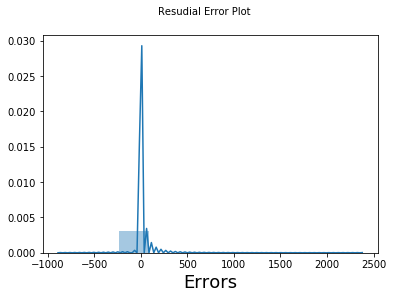

In [443]:
# Make predictions
Y_Train_Pred = lm.predict(X_Train_rfe)
#Resudial Analysis on train data
fig = plt.figure()
sns.distplot((Y_Train - Y_Train_Pred), bins = 10)
fig.suptitle('Resudial Error Plot', fontsize = 10)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

In [444]:
#print(math.sqrt(mean_squared_error(np.e**Y_Train - 1, (np.e**Y_Train_Pred - 1))))
#print(r2_score(np.e**Y_Train - 1,np.e**Y_Train_Pred - 1))
 
math.sqrt(mean_squared_error(Y_Train, Y_Train_Pred))

          

7.888441404327937

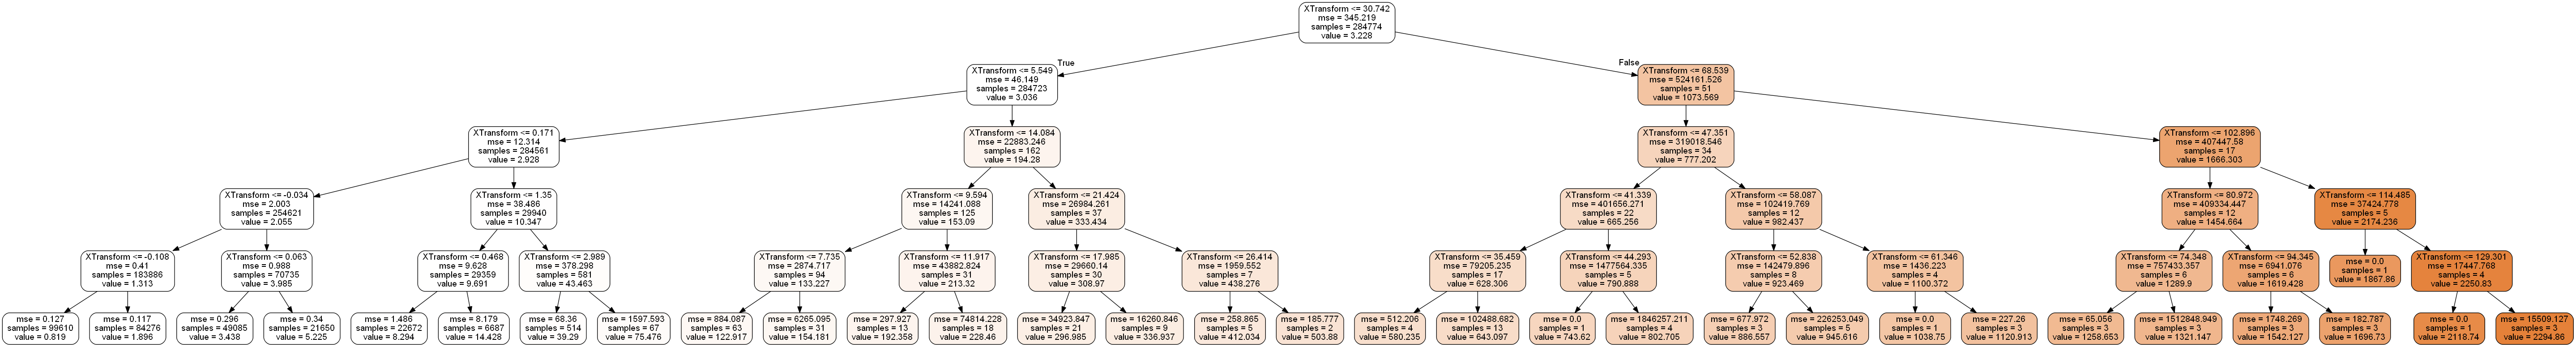

In [445]:
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus , graphviz
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeRegressor(max_depth = 5)
dt.fit(X_Train_rfe, Y_Train)

# Plotting the decision Tree
dot_data = StringIO()
export_graphviz(dt,out_file = dot_data,filled = True,rounded = True,feature_names = X_Train_rfe.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())




In [446]:
Y_Train_Pred = dt.predict(X_Train_rfe)
#math.sqrt(mean_squared_error(np.e**Y_Train - 1, np.e**Y_Train_Pred - 1))
math.sqrt(mean_squared_error(Y_Train, Y_Train_Pred))

7.771967274297095

In [447]:
# Working with the test data
test_data.shape

(122049, 2)

In [448]:
# Start Variable transformation
# Quantity
test_data['Is_Quantity_Neg'] = train_data['Quantity'].apply(lambda x:1 if x<0 else 0 )
train_data['Quantity'] = train_data['Quantity'].apply(lambda x:abs(x) if x<=0 else x )


# Stock Code
test_data = pd.merge(test_data,train_data_raw_stockcode,on = 'StockCode',how = 'left').reset_index(drop = True)
test_data['StockCodeTransform'] = test_data['StockCodeTransform'].fillna(train_data_raw_stockcode['StockCodeTransform'].mean())

#Country
test_data = pd.merge(test_data,train_data_raw_country,on = 'Country',how = 'left').reset_index(drop = True)
test_data['CountryTransform'] = test_data['CountryTransform'].fillna(train_data_raw_country['CountryTransform'].mean())




# Customer ID
test_data = pd.merge(test_data,train_data_raw_customer,on = 'CustomerID',how = 'left').reset_index(drop = True)
test_data['CustomerTransform'] = test_data['CustomerTransform'].fillna(train_data_raw_customer['CustomerTransform'].mean())

#Year Data
test_data['Year'] = test_data['InvoiceDate'].apply(lambda x:x.split(" ")[0][6:10])
test_data = pd.merge(test_data,train_data_raw_year,on = 'Year',how = 'left').reset_index(drop = True)

#Hour Data
test_data['Hour'] = test_data['InvoiceDate'].apply(lambda x:int(x.split(" ")[1][0:2]))
test_data = pd.merge(test_data,train_data_raw_hour,on = 'Hour',how = 'left').reset_index(drop = True)

#Month
test_data['Month'] = test_data['InvoiceDate'].apply(lambda x:int(x.split("-")[1]))
test_data = pd.merge(test_data,train_data_raw_month,on = 'Month',how = 'left').reset_index(drop = True)




test_data['UnitPrice']  = np.log1p(test_data['UnitPrice'])
# Drop Unwanted Columns
test_data = test_data.drop(columns_to_drop,axis = 1).reset_index(drop = True)
test_data.head(10)


NameError: name 'train_data_raw_stockcode' is not defined

In [449]:
# Prepare Dummies

#Stock Code
#stock_code = pd.get_dummies(test_data['StockCodeTransform'], drop_first = True,prefix = 'stock_code')
#test_data = pd.concat([test_data, stock_code], axis = 1)
#test_data = test_data.drop(['StockCodeTransform'],axis = 1)


#HourTransform
#hour = pd.get_dummies(test_data['HourTransform'], drop_first = True,prefix = 'hour')
#test_data = pd.concat([test_data, hour], axis = 1)
#test_data = test_data.drop(['HourTransform'],axis = 1)



#Season Transform
#season = pd.get_dummies(test_data['SeasonTransform'], drop_first = True,prefix = 'season')
#test_data = pd.concat([test_data, season], axis = 1)
#test_data = test_data.drop(['SeasonTransform'],axis = 1)

# Country Transform
#country = pd.get_dummies(test_data['CountryTransform'], drop_first = True,prefix = 'country')
#test_data = pd.concat([test_data, country], axis = 1)
#test_data = test_data.drop(['CountryTransform'],axis = 1)

#Customer Transform
#customer = pd.get_dummies(test_data['CustomerTransform'], drop_first = True,prefix = 'customer')
#test_data = pd.concat([test_data, customer], axis = 1)
#test_data = test_data.drop(['CustomerTransform'],axis = 1)


test_data.head()





,Quantity,XTransform,Is_Quantity_Neg
0,-0.030596,0.039929,1
1,-0.037373,0.039929,1
2,0.081220,0.117429,1
3,-0.033985,0.039929,1
4,-0.037373,0.991356,1


In [450]:
# Transform Quantity

#test_data[vars_to_scale] = scaler.transform(test_data[vars_to_scale])
#test_data.shape



In [451]:
# Final X and Y Variables for prediction
X_Test_rfe = test_data[X_Train.columns[rfe.support_]]
#X_Test_rfe = sm.add_constant(X_Test_rfe)
X_Test_rfe.head()


,XTransform
0,0.039929
1,0.039929
2,0.117429
3,0.039929
4,0.991356


In [452]:
# Model Eval
# Linear Regression
Y_Test_Pred = lm.predict(X_Test_rfe)
Y_Test = test_data[['UnitPrice']]
math.sqrt(mean_squared_error(np.e**Y_Test - 1, np.e**Y_Test_Pred - 1))
#math.sqrt(mean_squared_error(Y_Test['UnitPrice'], Y_Test_Pred))

KeyError: "None of [Index(['UnitPrice'], dtype='object')] are in the [columns]"

In [453]:
# Model Eval
# Decision Tree

Y_Test_Pred = dt.predict(X_Test_rfe)
math.sqrt(mean_squared_error(np.e**Y_Test - 1, np.e**Y_Test_Pred - 1))
#math.sqrt(mean_squared_error(Y_Test, Y_Test_Pred))


NameError: name 'Y_Test' is not defined

In [454]:
#df1 = pd.DataFrame(np.e**Y_Test - 1)
#df2 = pd.DataFrame(np.e**Y_Test_Pred - 1)
df1 = pd.DataFrame(Y_Test)
df2 = pd.DataFrame(Y_Test_Pred)
df = pd.concat([df1,df2],axis  = 1)
df.columns = ['Actual','Predicted']
df.to_csv('check_rsme.csv')

NameError: name 'Y_Test' is not defined

In [455]:
#### Final Submission

In [456]:
# Import test data
test_data  = pd.read_csv('Test.csv')
test_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country
0,3139,1709,1079,3,22-02-2011 15:22,16161,35
1,617,510,3457,1,08-12-2010 12:46,17341,35
2,14653,604,694,36,25-10-2011 13:53,15158,35
3,8634,1478,3473,2,27-06-2011 12:38,16033,35
4,15546,3216,871,1,06-11-2011 16:14,15351,35


In [457]:
# Add a rank column for repeat transactions

test_data['RepeatRank']= test_data.groupby(['StockCode','InvoiceDate','Country'])['InvoiceNo'].cumcount()+1
test_data['Date'] = test_data['InvoiceDate'].apply(lambda x:x.split(" ")[0])
test_data = pd.merge(test_data,train_data_raw_x,on = ['StockCode','Date','Country','RepeatRank'],how = 'left').reset_index(drop = True)
test_data['XTransform'] = test_data['XTransform'].fillna(train_data_raw_x['XTransform'].mean())

test_data = test_data.drop(columns_to_drop,axis  = 1)
test_data[vars_to_scale] = scaler.transform(test_data[vars_to_scale])
print(test_data.shape)
test_data.head()

(122049, 2)


,Quantity,XTransform
0,-0.030594,0.015237
1,-0.037371,0.015237
2,0.081227,0.058601
3,-0.033983,0.015237
4,-0.037371,0.547591


In [458]:
# Start Variable transformation
'''
# Quantity
test_data['Is_Quantity_Neg'] = test_data['Quantity'].apply(lambda x:1 if x<0 else 0 )
test_data['Quantity'] = test_data['Quantity'].apply(lambda x:abs(x) if x<=0 else x )
test_data['Quantity'] = test_data['Quantity'].apply(lambda x:upper_cutoff if x>=upper_cutoff else x )




# Stock Code
#test_data = pd.merge(test_data,train_data_raw_stockcode,on = 'StockCode',how = 'left').reset_index(drop = True)
#test_data['StockCodeTransform'] = test_data['StockCodeTransform'].fillna(train_data_raw_stockcode['StockCodeTransform'].mean())

#Country
test_data = pd.merge(test_data,train_data_raw_country,on = ['Country','StockCode'],how = 'left').reset_index(drop = True)
test_data['CountryTransform'] = test_data['CountryTransform'].fillna(train_data_raw_country['CountryTransform'].mean())

#Date
test_data['Date'] = test_data['InvoiceDate'].apply(lambda x:x.split(" ")[0])
test_data = pd.merge(test_data,train_data_raw_date,on = ['Date','StockCode'],how = 'left').reset_index(drop = True)
test_data['DateTransform'] = test_data['DateTransform'].fillna(train_data_raw_date['DateTransform'].mean())



#test_data['UnitPrice']  = np.log1p(test_data['UnitPrice'])
# Drop Unwanted Columns
test_data = test_data.drop(columns_to_drop,axis = 1).reset_index(drop = True)
test_data.head(10)
'''

'\n# Quantity\ntest_data[\'Is_Quantity_Neg\'] = test_data[\'Quantity\'].apply(lambda x:1 if x<0 else 0 )\ntest_data[\'Quantity\'] = test_data[\'Quantity\'].apply(lambda x:abs(x) if x<=0 else x )\ntest_data[\'Quantity\'] = test_data[\'Quantity\'].apply(lambda x:upper_cutoff if x>=upper_cutoff else x )\n\n\n\n\n# Stock Code\n#test_data = pd.merge(test_data,train_data_raw_stockcode,on = \'StockCode\',how = \'left\').reset_index(drop = True)\n#test_data[\'StockCodeTransform\'] = test_data[\'StockCodeTransform\'].fillna(train_data_raw_stockcode[\'StockCodeTransform\'].mean())\n\n#Country\ntest_data = pd.merge(test_data,train_data_raw_country,on = [\'Country\',\'StockCode\'],how = \'left\').reset_index(drop = True)\ntest_data[\'CountryTransform\'] = test_data[\'CountryTransform\'].fillna(train_data_raw_country[\'CountryTransform\'].mean())\n\n#Date\ntest_data[\'Date\'] = test_data[\'InvoiceDate\'].apply(lambda x:x.split(" ")[0])\ntest_data = pd.merge(test_data,train_data_raw_date,on = [\'Dat

In [459]:
# Prepare Dummies

#Stock Code
#stock_code = pd.get_dummies(test_data['StockCodeTransform'], drop_first = True,prefix = 'stock_code')
#test_data = pd.concat([test_data, stock_code], axis = 1)
#test_data = test_data.drop(['StockCodeTransform'],axis = 1)


#HourTransform
#hour = pd.get_dummies(test_data['HourTransform'], drop_first = True,prefix = 'hour')
#test_data = pd.concat([test_data, hour], axis = 1)
#test_data = test_data.drop(['HourTransform'],axis = 1)



#Season Transform
#season = pd.get_dummies(test_data['SeasonTransform'], drop_first = True,prefix = 'season')
#test_data = pd.concat([test_data, season], axis = 1)
#test_data = test_data.drop(['SeasonTransform'],axis = 1)

# Country Transform
#country = pd.get_dummies(test_data['CountryTransform'], drop_first = True,prefix = 'country')
#test_data = pd.concat([test_data, country], axis = 1)
#test_data = test_data.drop(['CountryTransform'],axis = 1)

#Customer Transform
#customer = pd.get_dummies(test_data['CustomerTransform'], drop_first = True,prefix = 'customer')
#test_data = pd.concat([test_data, customer], axis = 1)
#test_data = test_data.drop(['CustomerTransform'],axis = 1)


test_data.head()





,Quantity,XTransform
0,-0.030594,0.015237
1,-0.037371,0.015237
2,0.081227,0.058601
3,-0.033983,0.015237
4,-0.037371,0.547591


In [460]:
# Transform Quantity
'''
test_data[vars_to_scale] = scaler.transform(test_data[vars_to_scale])
test_data.shape
'''


'\ntest_data[vars_to_scale] = scaler.transform(test_data[vars_to_scale])\ntest_data.shape\n'

In [461]:
# Model Eval
# 
X_Test_rfe = test_data[X_Train.columns[rfe.support_]]
Y_Test_Pred = lm.predict(X_Test_rfe)
#Y_Test_Pred = dt.predict(test_data)
pd.DataFrame(Y_Test_Pred).to_csv('Amit_Soni_Submission_40_lm.csv')



In [462]:
# Model Eval
# Decision Tree

Y_Test_Pred = dt.predict(X_Test_rfe)
pd.DataFrame(Y_Test_Pred).to_csv('Amit_Soni_Submission_40_dt.csv')
